In [5]:
import numpy as np
import librosa
import os
import torch.nn as nn
import torch
import torchaudio

In [16]:
class Dataset:
    def __init__(self, path_folder):
        self.song_names = os.listdir(path_folder)
        self.song_paths = [os.path.join(path_folder, song_name) for song_name in self.song_names]

    def __getitem__(self, idx):
        wav, sr = librosa.load(self.song_paths[idx], sr=16000)
        wav = torch.tensor(wav, dtype=torch.float32).unsqueeze(0)
        return wav, sr
    def __len__(self):
        return len(self.song_paths)

In [21]:
from google.colab import drive
drive.mount('/MyDrive')
path_folder = '/MyDrive/MyDrive/my_projects/songs'

Drive already mounted at /MyDrive; to attempt to forcibly remount, call drive.mount("/MyDrive", force_remount=True).


In [17]:
d = Dataset(path_folder)
d[0][0].shape, d[0][1]

(torch.Size([1, 2760638]), 16000)

In [18]:
import torch
import numpy as np
from torch.nn.utils.rnn import pad_sequence
class Collate:
    def __init__(self, transforms) -> None:
        super(Collate, self).__init__()
        self.transforms = transforms

    def __call__(self, batch):
        batch_S, batch_sr = zip(*batch)
        # маска для паддинга
        max_len = max(elem.shape[1] for elem in batch_S) # Максимальный time
        mask = []
        for s in batch_S:
            m = [False] * s.shape[1] + [True] * (max_len - s.shape[1])
            mask.append(m)
        mask = torch.tensor(mask, dtype=torch.bool)

        transformed_S = [self.transforms(S) for S in batch_S] # содержит тензоры вида (mel, time)
        transformed_S = [elem.T for elem in transformed_S]    # содержит тензоры вида (time, mel)
        pad_S = pad_sequence(transformed_S, batch_first=True) # является тензором вида (B, time, mel)
        pad_S = pad_S.permute(0, 2, 1)                        # является тензором вида (B, mel, time)




        return pad_S, mask, batch_sr


In [19]:
import torchaudio.transforms as T
from torch import nn

class squeeze_channel(nn.Module):
    def forward(self, x):
        return x.squeeze(0)
audio_transforms = nn.Sequential(
    T.MelSpectrogram(n_mels=32), # (1, N) -> (1, mels, time)
    T.AmplitudeToDB(),
    squeeze_channel(), #  (1, mels, time) ->  (mels, time)
)

In [22]:
from torch.utils.data import DataLoader
# path_folder = 'C:/vs_code_ml/audio/songs'
dataloader = DataLoader(
    dataset=Dataset(path_folder),
    batch_size=1,
    shuffle=True,
    num_workers=0,
    collate_fn=Collate(audio_transforms)
)

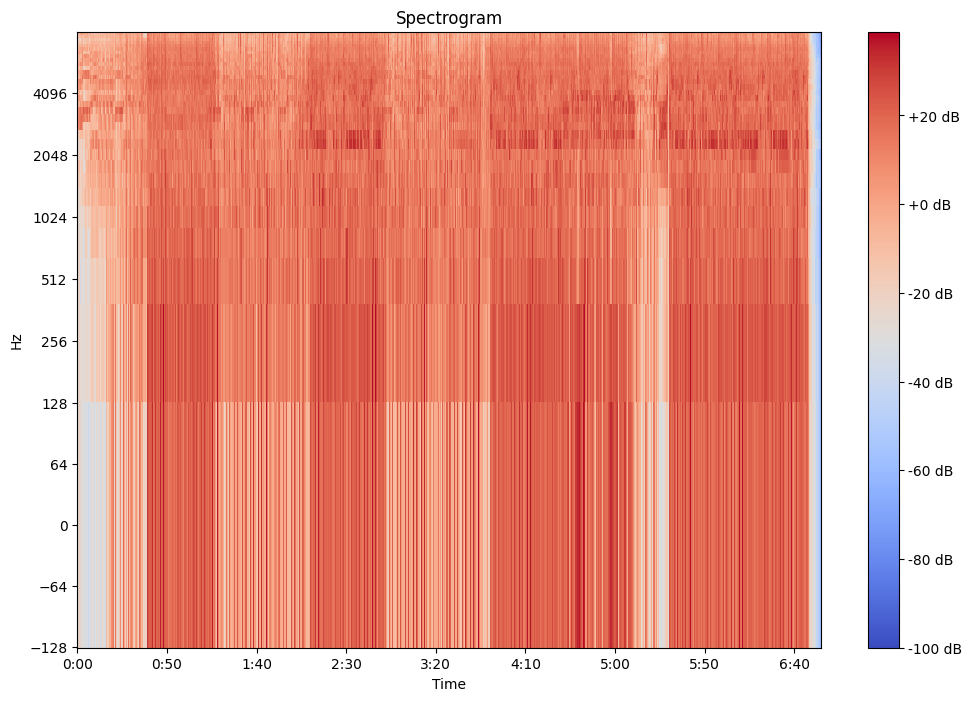

In [23]:
import matplotlib.pyplot as plt
feauters, mask, sr = next(iter(dataloader))
plt.figure(figsize=(12, 8))
librosa.display.specshow(feauters[0].numpy(), sr=sr[0], x_axis='time', y_axis='log')
plt.colorbar(format="%+2.0f dB")
plt.title('Spectrogram')
plt.show()

# Модель

In [33]:
import torch
import torch.nn as nn
import math

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=40000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (T, 1, D)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return x

class AudioTransformer(nn.Module):
    def __init__(self, mel_bins=32, d_model=128, nhead=4, ff_dim=256, n_layers=4, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(mel_bins, d_model)
        self.pos_enc = SinusoidalPositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, ff_dim, dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, pad_mask=None):
        # x: (B, mel, T)
        x = x.permute(0, 2, 1)            # (B, T, mel)
        x = self.input_proj(x)            # (B, T, d_model)
        x = x.permute(1, 0, 2)            # (T, B, d_model)
        x = self.pos_enc(x)               # (T, B, d_model)
        out = self.encoder(x, src_key_padding_mask=pad_mask)  # (T, B, d_model)
        out = out.permute(1, 0, 2)        # (B, T, D)
        out = self.norm(out)

        # усреднение по времени (можно заменить на [CLS])
        return out.mean(dim=1)            # (B, D)


# Triplet Dataset

In [25]:
import random
from torch.utils.data import Dataset

class TripletAudioDataset(Dataset):
    def __init__(self, songs, transform):
        self.songs = songs  # список путей к аудиофайлам
        self.transform = transform

    def __len__(self):
        return len(self.songs)

    def __getitem__(self, idx):
        anchor_path = self.songs[idx]
        positive_path = anchor_path  # целевая песня

        # случайный негатив
        negative_path = random.choice([p for i, p in enumerate(self.songs) if i != idx])

        # аудиофрагменты
        anchor = self.transform(anchor_path, crop=True)
        positive = self.transform(positive_path, crop=False)
        negative = self.transform(negative_path, crop=False)

        return anchor, positive, negative


# Аудио трансформация

In [26]:
import torchaudio
import torchaudio.transforms as T

mel_transform = nn.Sequential(
    T.MelSpectrogram(n_mels=32),
    T.AmplitudeToDB()
)

def load_and_process(path, crop=False):
    wav, sr = torchaudio.load(path)
    if crop:
        wav = wav[:, :sr * 5]  # 5 сек, например
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    mel = mel_transform(wav)   # (1, mels, time)
    return mel.squeeze(0)      # (mels, time)


# Triplet Loss

In [27]:
import torch.nn.functional as F

def triplet_loss(anchor, positive, negative, margin=0.3):
    d_pos = F.cosine_similarity(anchor, positive)
    d_neg = F.cosine_similarity(anchor, negative)
    loss = F.relu(d_neg - d_pos + margin).mean()
    return loss


# Обучение

In [ ]:
from torch.utils.data import DataLoader
songs_list = [os.path.join(path_folder, song_name) for song_name in os.listdir(path_folder)]
num_epochs = 10

model = AudioTransformer()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

dataset = TripletAudioDataset(songs_list, transform=load_and_process)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

model.train()
for epoch in range(num_epochs):
    for anchor, positive, negative in loader:
        # формы: (B, mel, T)
        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)

        loss = triplet_loss(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch}: loss={loss.item():.4f}")
